# Examples for the QuantFin Library
## Author: Gustavo Amarante

I built this library during my studies for the CQF. I know I am not the first one to program these functionalities, but doing so helped me truly understand them.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---
# Option Pricing

## Black-Scholes Model

This class creates an object that contains options characteristics as attributes. There are two ways to instanciate the class:

1. Give an estimate of the volaltility to compute the price based on the model.
1. Give the observed price of the option and let the model compute the implied volatility.

In [2]:
from quantfin.options import BlackScholes

Giving an estimate of the volatility

In [3]:
bs = BlackScholes(stock_price=100, 
                  strike_price=90, 
                  maturity=1, 
                  risk_free=0.05, 
                  vol=0.4, 
                  div_yield=0, 
                  call=True,
                  option_type='european')

bs.price

22.984789059492478

Giving the observed price of the option from this last example as an input. For this we use the `from_price` method to instanciate the class. Notice that it finds the implied volatility to also be the same as the previous example.

In [4]:
bs = BlackScholes.from_price(stock_price=100, 
                             strike_price=90, 
                             maturity=1, 
                             risk_free=0.05, 
                             option_price=22.984789,
                             div_yield=0, 
                             call=True, 
                             option_type='european')

bs.vol

0.3999999982269052

This `BlackScholes` class also has the traditional **greeks** as attributes. Below, we chart the greeks of calls and puts as a function of the underlying stock price

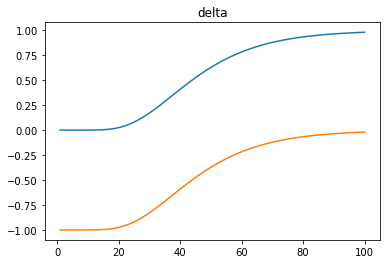

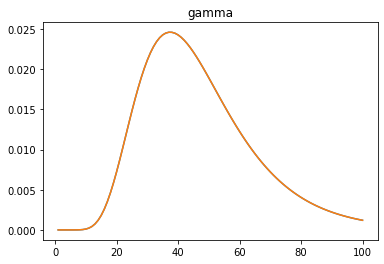

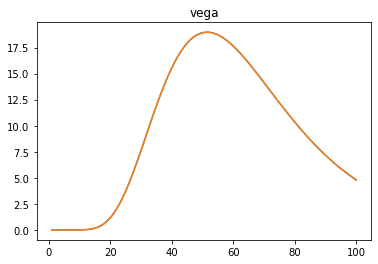

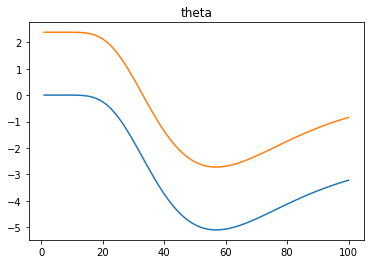

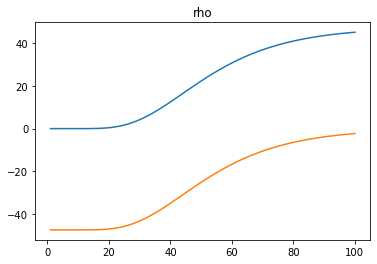

In [6]:
def bs_greeks(S):
    bs = BlackScholes(stock_price=S, 
                      strike_price=50, 
                      maturity=1, 
                      risk_free=0.05, 
                      vol=0.4, 
                      div_yield=0, 
                      call=True,
                      option_type='european')

    greeks_call = {'delta': bs.delta,
                   'gamma': bs.gamma,
                   'vega': bs.vega,
                   'theta': bs.theta,
                   'rho': bs.rho}
    
    bs = BlackScholes(stock_price=S, 
                      strike_price=50, 
                      maturity=1, 
                      risk_free=0.05, 
                      vol=0.4, 
                      div_yield=0, 
                      call=False,
                      option_type='european')

    greeks_put = {'delta': bs.delta,
                  'gamma': bs.gamma,
                  'vega': bs.vega,
                  'theta': bs.theta,
                  'rho': bs.rho}
    
    return greeks_call, greeks_put


df_call = pd.DataFrame(columns=['delta', 'gamma', 'vega', 'theta', 'rho'])
df_put = pd.DataFrame(columns=['delta', 'gamma', 'vega', 'theta', 'rho'])
for sprice in np.linspace(1, 100, 100):
    c, p = bs_greeks(sprice)
    df_call.loc[sprice] = c
    df_put.loc[sprice] = p

for col in df_call.columns:
    df_call[col].plot(title=col)
    df_put[col].plot()
    plt.show()
    

## Binomial Tree Model

In [7]:
from quantfin.options import BinomalTree

The `BinomialTree` class can price american/european calls/puts.

As a first example here is the price of an american put option on a stock.

In [8]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='american')

bt.price

2.7452952388441347

If we change the option type to european, we are not allowed to exercise the option before maturity, restricting the possibilities of making a profit. So an european put should be cheaper than an american put.

In [9]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='european')

bt.price

2.6389737155978104

There is also the option for binary options

In [10]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=True,
                 option_type='binary')

bt.price

0.7057802588632299

The model assumes that the underlying stock price evolves through a binomial tree. You can use the `chart_stock` method to see the trajectories of this tree. The example below uses 3 steps.

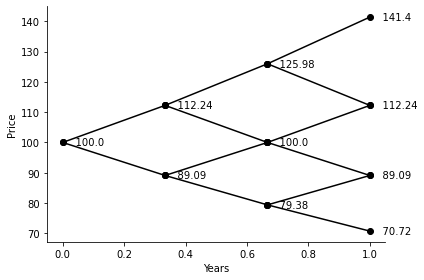

In [11]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=3,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=True)
plt.show()

We can also build a tree with more steps and hide the labels.

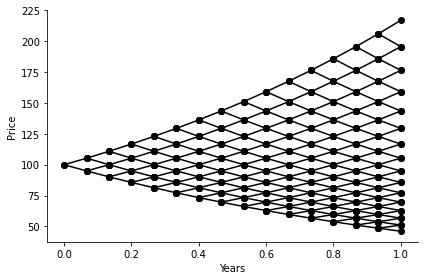

In [12]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=15,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=False)
plt.show()

As we have learned, as the number of steps/subdivision of the binomial tree increases, the price of the Binomial model converges to the Black-Scholes-Merton model. We can run the `BinomialTree` for several values of `n` and see how does the price converges.

We can see on the chart below that the convergence is not smooth.

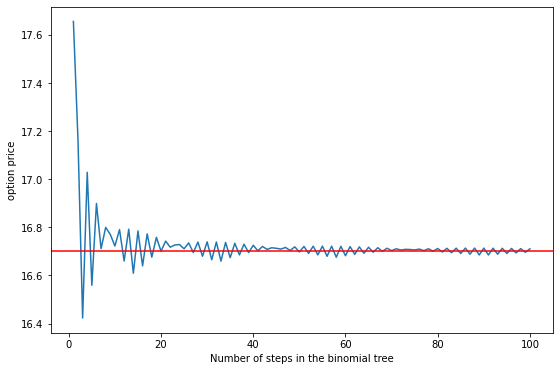

In [13]:
bs = BlackScholes(stock_price=100, strike_price=90, maturity=1, risk_free=0.05, vol=0.2).price

def option_price(n=1):
    return BinomalTree(stock=100, strike=90, years2mat=1, vol=0.20, risk_free=0.05, n=n).price


n_grid = np.arange(1, 101, 1, dtype=int)

plt.figure(figsize=(9, 6))
plt.plot(n_grid, list(map(option_price, n_grid)))
plt.axhline(bs, color='red')
plt.xlabel('Number of steps in the binomial tree')
plt.ylabel('option price')
plt.show()

---
# Portfolio Construction

## Markowitz

In [14]:
from quantfin.portfolio import Markowitz

The first example is with the corner case of only 1 risk asset

In [15]:
# pandas series of expected returns
mu = pd.Series(data={'A': 0.1},
               name='mu')

# pandas series of risk
sigma = pd.Series(data={'A': 0.2},
                  name='sigma')

# pandas dataframe of correlations
corr = [[1]]
corr = pd.DataFrame(columns=['A'],
                    index=['A'],
                    data=corr)

Run the optimization

In [16]:
mkw = Markowitz(mu, sigma, corr,
                rf=0.02,
                risk_aversion=3.2)

Get the weights

In [17]:
mkw.weight_p

0.6249999999999999

We can also plot the risk-return plane (although it is not very interesting for the 1 asset case since the asset, the optimal risk and the minimum variance portfolios are all the same)

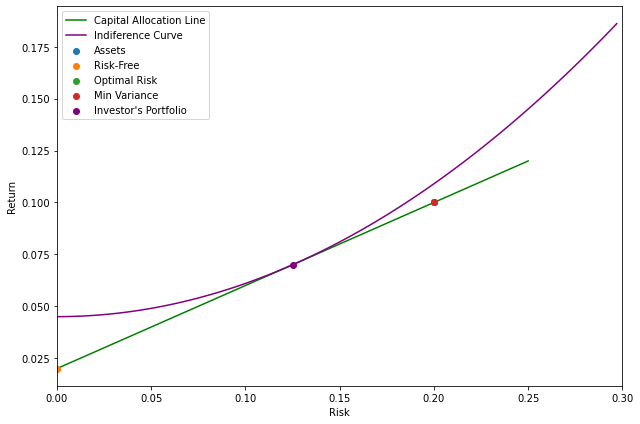

In [18]:
mkw.plot(figsize=(9, 6))

For this next example we are going to use an example with 3 risky assets. The cell below sets the characteristics of the risky assets.

In [19]:
# pandas series of expected returns
mu = pd.Series(data={'A': 0.10,
                     'B': 0.15,
                     'C': 0.08},
               name='mu')

# pandas series of risk
sigma = pd.Series(data={'A': 0.20,
                        'B': 0.30,
                        'C': 0.30},
                  name='sigma')

# pandas dataframe of correlations
corr = [[1.0, 0.3, 0.0],
        [0.3, 1.0, 0.0],
        [0.0, 0.0, 1.0]]

corr = pd.DataFrame(columns=['A', 'B', 'C'],
                    index=['A', 'B', 'C'],
                    data=corr)

Now we also choose the risk-free rate and the investor's risk aversion.

In [20]:
mkw = Markowitz(mu, sigma, corr,
                rf=0.05,
                risk_aversion=4)

We can grab the solutions on the attributes of `mkw`.

In [21]:
mkw.risky_weights

A    0.391754
B    0.449800
C    0.158446
Name: Risky Weights, dtype: float64

In [22]:
mkw.complete_weights

A            0.206041
B            0.236570
C            0.083334
Risk Free    0.474055
Name: Risky Weights, dtype: float64

We can also plot the results on the tradition risk-return plane.

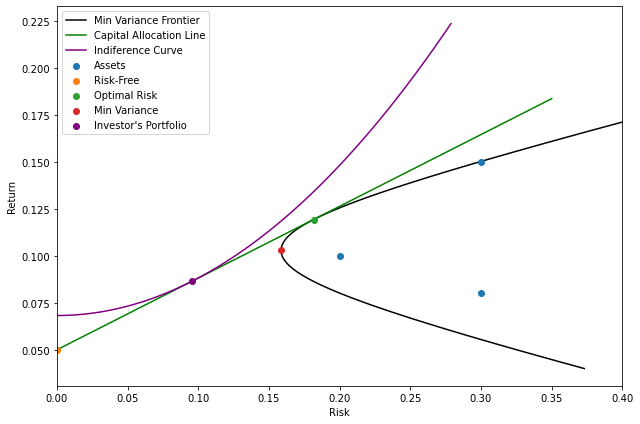

In [23]:
mkw.plot(figsize=(9, 6))

Let us run the optimization again, but now with a short-selling constraint. Notice how the shape of minimum variance frontier changes.

Also, since there is no analytical solution to find the minimal variance frontier, several optimizations need to run and compute the minimal variance frontier point by point. So `plot` method may take a little longer to run when `short_sell=False`.

Finding Mininmal variance frontier: 100%|██████████| 100/100 [00:01<00:00, 67.89it/s]


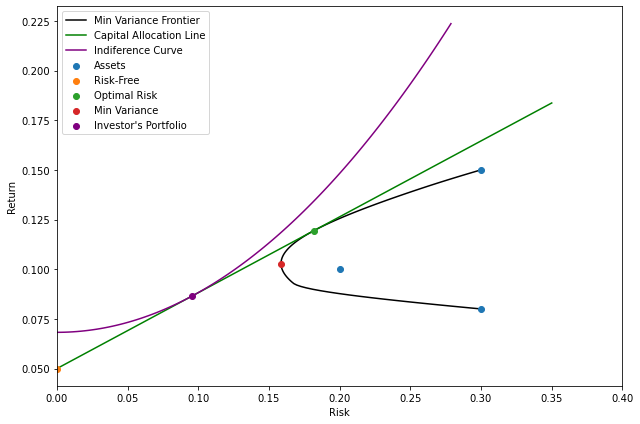

In [24]:
mkw = Markowitz(mu, sigma, corr,
                rf=0.05,
                risk_aversion=4,
               short_sell=False)

mkw.plot(figsize=(9, 6))

---
# Portfolio - Performance Evaluation

For the purpose of ilustration, we are going to select 3 stocks and grab the data using the pandas DataReader API.

In [25]:
import pandas_datareader.data as web
f = web.DataReader(['AAPL', 'GOOG', 'TSLA'], 'stooq')
f = f['Close'].sort_index()
f

Symbols,AAPL,GOOG,TSLA
Date,,,
2016-03-29,25.042,744.77,46.026
2016-03-30,25.476,750.53,45.378
2016-03-31,25.343,744.95,45.954
2016-04-01,25.573,749.91,47.518
2016-04-04,25.838,745.29,49.398
...,...,...,...
2021-03-22,123.390,2038.59,670.000
2021-03-23,122.540,2052.96,662.160
2021-03-24,120.090,2045.06,630.270


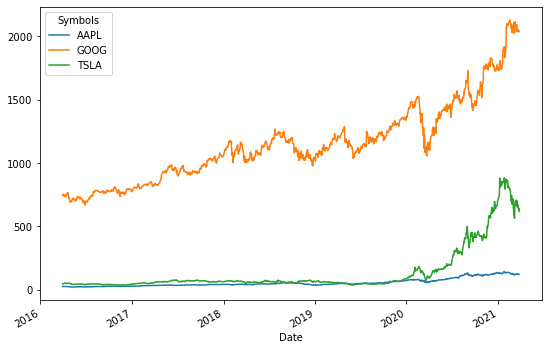

In [26]:
f.plot(figsize=(9, 6))
plt.show()

Now we import the `Performance` library

In [27]:
from quantfin.portfolio import Performance
perf = Performance(f)

The `table` attribute holds a DataFrame with the major performance indicators, reported in annualized basis.

In [28]:
perf.table

Symbols,AAPL,GOOG,TSLA
Return,0.371487,0.223125,0.682889
Volatility,0.303257,0.266259,0.589356
Sharpe,1.224989,0.838000,1.158705
Skewness,-0.068279,-0.094879,0.300424
Kurtosis,6.953439,6.546698,5.696847
Sortino,1.602744,1.067662,1.668914
Max Drawdown,-0.385164,-0.307901,-0.606257


The `drawdown` attribute holds a MultiIndex DataFrame with the sorted list of drawdowns and their dates.

In [29]:
perf.drawdowns

dd last start        end
AAPL 0  -0.385164 2018-10-03 2019-01-03
     1  -0.314275 2020-02-12 2020-03-23
     2  -0.203738 2020-09-01 2020-09-18
     3  -0.189056 2016-04-14 2016-05-12
     4  -0.134497 2018-01-18 2018-02-08
...           ...        ...        ...
TSLA 29 -0.014079 2016-03-29 2016-03-30
     30 -0.011323 2020-08-27 2020-08-28
     31 -0.009738 2020-06-08 2020-06-09
     32 -0.004531 2020-08-18 2020-08-19
     33 -0.003402 2017-05-31 2017-06-02

[166 rows x 3 columns]

The `plot_drawdowns` method plots the total return index and highlights the `n` worst drawdown periods.

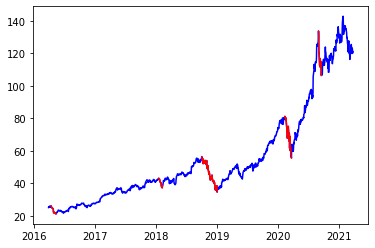

In [30]:
perf.plot_drawdowns('AAPL')

The `plot_underwater` method plots the the current drawdown.

No handles with labels found to put in legend.


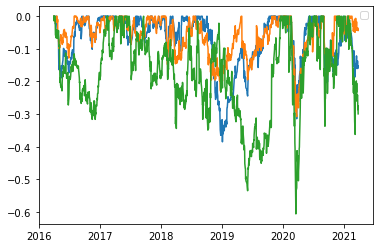

In [31]:
perf.plot_underwater()

---
# Simulation

## Brownian Motion (Scaled binary random walk)

Define the "coin toss" process as:

$$
X_{j}=\begin{cases}
1 & if\;\omega_{j}\leq\frac{1}{2}\\
-1 & if\;\omega_{j}>\frac{1}{2}
\end{cases}
$$

The scaled random walk  is defined as

$$
W_{t}^{\left(n\right)}=\frac{1}{\sqrt{n}}\sum_{j=1}^{nt}X_{j}
$$

In [32]:
from quantfin.simulation import BrownianMotion

We can simulate the scaled random walk for the same period $T$ but with different different values of $n$.

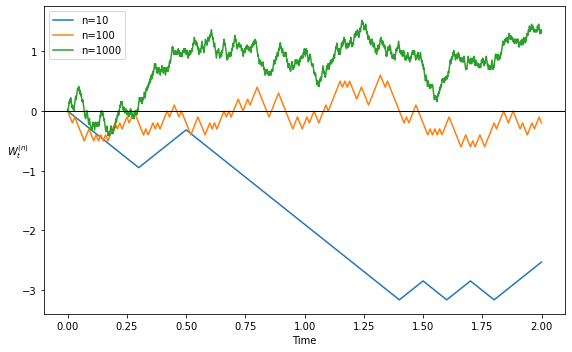

In [33]:
df = pd.DataFrame()

bm = BrownianMotion(T=2, n=10, k=1)
df = pd.concat([df, bm.simulated_trajectories.iloc[:, 0].rename('n=10')], axis=1)

bm = BrownianMotion(T=2, n=100, k=1)
df = pd.concat([df, bm.simulated_trajectories.iloc[:, 0].rename('n=100')], axis=1)

bm = BrownianMotion(T=2, n=1000, k=1)
df = pd.concat([df, bm.simulated_trajectories.iloc[:, 0].rename('n=1000')], axis=1)

df = df.interpolate(method='linear', limit_area='inside')
df.plot(figsize=(5 * 1.61, 5))
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Time')
plt.ylabel('$W_{t}^{(n)}$', rotation=0)
plt.tight_layout()
plt.show()

## Diffusion Processes
This classes is used to simulate and compute characteristics of classic diffusion processes of the finance literature. For now, the supported processes are:
* Simple Brownian Motion (`bm`)
* Random Walk with Drift (`rwwd`)
* Geometric Brownian Motion / Log-Normal Random Walk / Price Process (`gbm`)
* Ornstein-Uhlenbeck / Mean-Reverting Process (`ou`)

Beyond simulating this processes, the class also computes the theoretical mean and standard deviation, and computes the confidence intervals based on the theoretical distribution of the processes.

In [34]:
from quantfin.simulation import Diffusion

### Simple Brownian Motion
$$
dW_{t}
$$

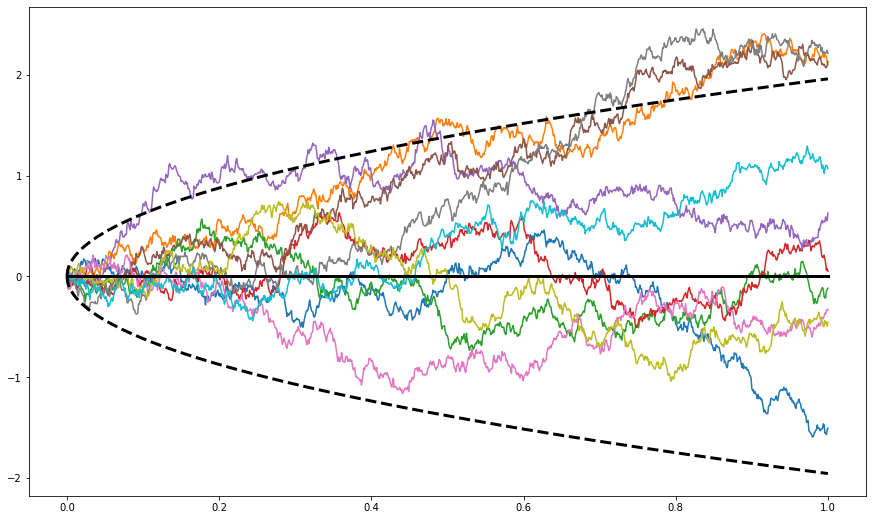

In [35]:
diff = Diffusion(T=1,  # 1-year horizon
                 n=1000,  # 1000 observation (discretization of the continous process)
                 k=10)  # simulate 10 trajectories

diff.brownian_motion.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Random Walk with Drift
$$
dS_{t}=\mu dt+\sigma dW_{t}
$$

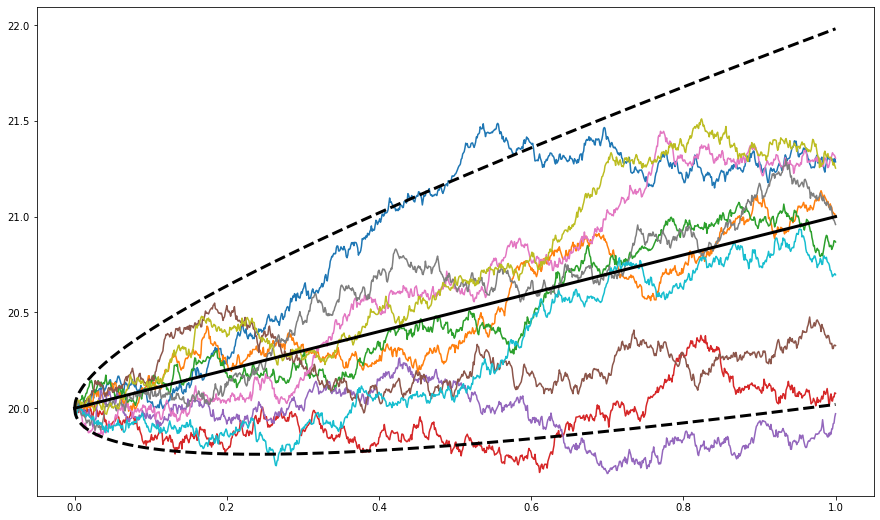

In [36]:
diff = Diffusion(T=1, 
                 n=1000, 
                 k=10, 
                 initial_price=20,  # set the initial price 
                 process_type='rwwd',  # set the process type 
                 drift=1,
                 diffusion=0.5)

diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Geometric Brownian Motion
$$
dS_{t}=\mu S_{t}dt+\sigma S_{t}dW_{t}
$$

Notice that the geometric brownian motion has a log-normal distribution, which is assymetric. So we cannot calculate confidence interevals by adding and subtracting standard deviations from the mean, we need to take into account the quantiles of the distribution. So notice that the confidence interval, in this case, are assymetric as well.

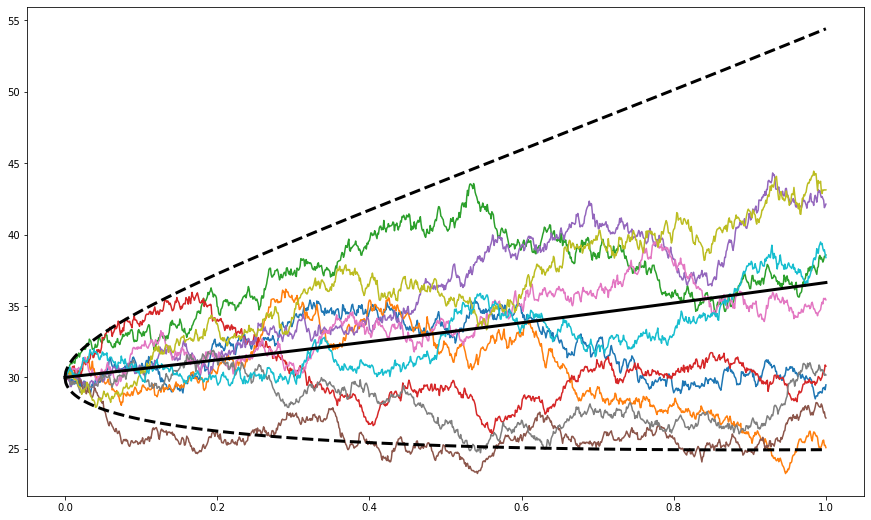

In [37]:
diff = Diffusion(T=1, n=1000, k=10, initial_price=30, process_type='gbm', drift=0.2, diffusion=0.2)

diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Mean Reversion Process
$$
dS_{t}=\theta\left(\mu-S_{t}\right)dt+\sigma dW_{t}
$$

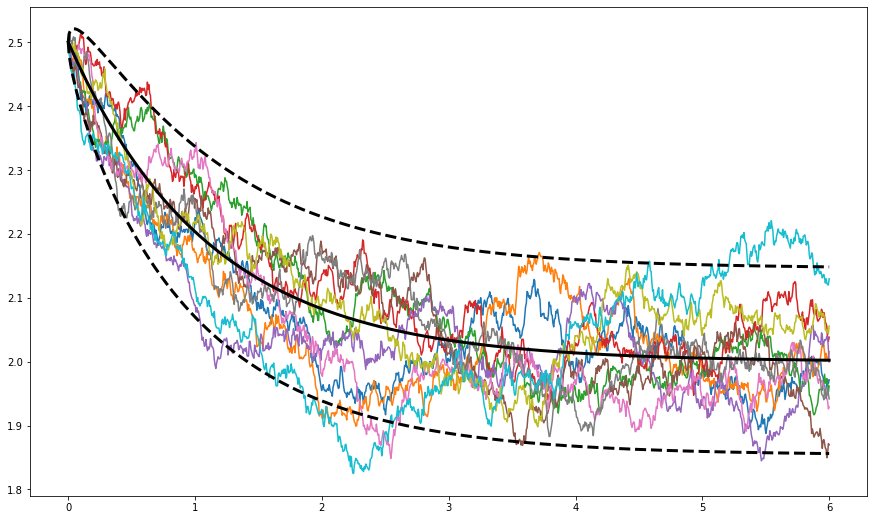

In [38]:
diff = Diffusion(T=6,   # lets look at a longer period to see the conversion
                 n=1000, 
                 k=10, 
                 initial_price=2.5,  # Start the process far from the mean
                 process_type='ou', 
                 drift=0.9,          # for the 'ou' process, 'drift' is the decay parameter...
                 mean=2,             # ... and 'mean' represents the 'mu'.
                 diffusion=0.1)


diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

## Multivariate Geometric Brownian Motion
This process is in a different class from the other diffusion processes. We have to import `MultivariateGBM`.

In [39]:
from quantfin.simulation import MultivariateGBM

A multivariate geometric brownian motion (MGBM) can be specified by a system of stochastic differential equations:

$$
\frac{dS_{i}\left(t\right)}{S_{i}\left(t\right)}=\mu_{i}dt+\sigma_{i}dW_{i}\left(t\right)
$$

But in this case, $dW\left(t\right)$ is a vector of brownian motions with zero mean and covariance matrix $\Sigma$, where $\Sigma_{ij}=\sigma_{i}\sigma_{j}\rho_{ij}$.

Notice that the input for the class is the correlation matrix, not the covariance.

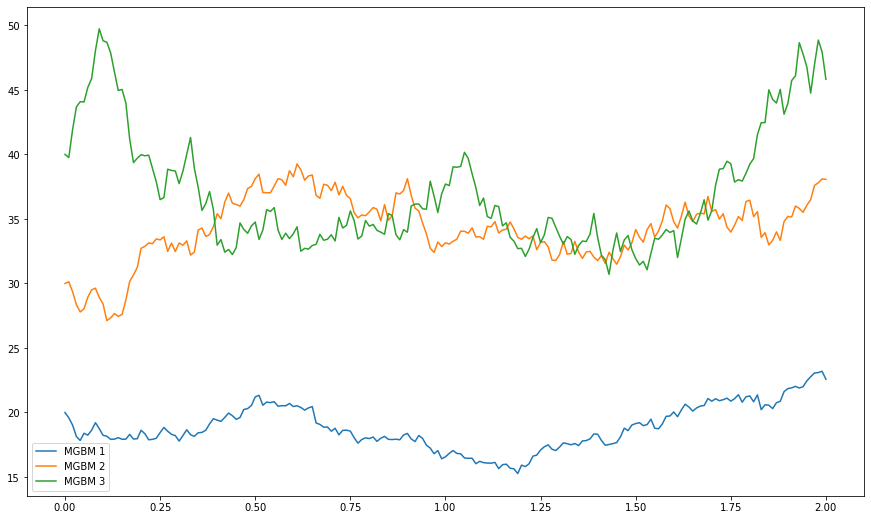

In [40]:
mu = [0.1, 0.15, 0.2]
sigma = [0.2, 0.2, 0.3]

corr = [[1.0,  0.6,  0.0],
        [0.6,  1.0, -0.4],
        [0.0, -0.4,  1.0]]

Sigma = np.diag(sigma) @ corr @ np.diag(sigma)

initial_price = [20, 30, 40]

mgbm = MultivariateGBM(T=2, n=200, 
                       mu=mu, sigma=Sigma, 
                       initial_price=initial_price,
                       random_seed=123)

mgbm.simulated_trajectories.plot(figsize=(15, 9))
plt.show()

To visualize the correlation, we have to look at the returns. We can see that the correlation matrix of the simulated returns is very close to the one "real" one.

In [41]:
mgbm.simulated_trajectories.pct_change().corr()

,MGBM 1,MGBM 2,MGBM 3
MGBM 1,1.000000,0.559716,-0.012523
MGBM 2,0.559716,1.000000,-0.363549
MGBM 3,-0.012523,-0.363549,1.000000


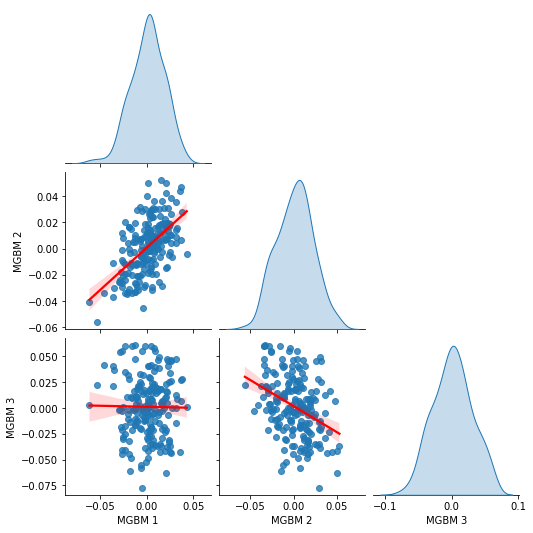

In [42]:
df_returns = mgbm.simulated_trajectories.pct_change()
sns.pairplot(data=df_returns,
             kind='reg',
             diag_kind='kde',
             corner=True,
             plot_kws={'line_kws': {'color': 'red'}})

plt.show()

## Random Correlation Matrix

To do simulations, sometimes we might need a correlation matrix. But as simulations get bigger, setting the values of a correlation matrix by hand becomes a hard process. We have to make sure that we have a positive-definite matrix. This function generates a andom matrices with the correct properties, based on the number of commom factors in the data.

In [43]:
from quantfin.simulation import random_correlation

n_col = 5      # dimension of the matrix
n_factors = 2  # number of commom factors in the data

corr = random_correlation(n_col, n_factors, random_seed=123)

corr

array([[ 1.        , -0.721432  ,  0.75683628,  0.52320477, -0.86982807],
       [-0.721432  ,  1.        , -0.91838397, -0.01003118,  0.67314562],
       [ 0.75683628, -0.91838397,  1.        ,  0.1433235 , -0.73043251],
       [ 0.52320477, -0.01003118,  0.1433235 ,  1.        , -0.64969125],
       [-0.86982807,  0.67314562, -0.73043251, -0.64969125,  1.        ]])

---
# Statistics
This sublibrary contains statistical utilities.

## Denoising Correlation Matrices

### Marchenko-Pastur theorem
This function replicates the method presented by Marcos Lopez de Prado (2020) to denoise correlation matrices, which is baded on the [Marchenko-Pastur theorem](https://en.wikipedia.org/wiki/Marchenko–Pastur_distribution).

In [44]:
from quantfin.statistics import denoise_corr_mp

T = 50  # we are assuming that we have 50 observations (returns) of 5 variables (assets)
N = 5

corr = denoise_corr_mp(corr, T, N)
corr

array([[ 1.        , -0.65629515,  0.66827572,  0.50000314, -0.67934541],
       [-0.65629515,  1.        , -0.64545   , -0.48292496,  0.65614159],
       [ 0.66827572, -0.64545   ,  1.        ,  0.49174069, -0.66811936],
       [ 0.50000314, -0.48292496,  0.49174069,  1.        , -0.49988615],
       [-0.67934541,  0.65614159, -0.66811936, -0.49988615,  1.        ]])